In [1]:
%matplotlib inline
import numpy as np

import matplotlib.pyplot as plt
from scipy.optimize import minimize

from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import add_beam, add_scalebar
import astropy.units as u
import pickle

# following imports needed for EMCEE fits
import emcee
import corner
import os
from IPython.display import display, Math

plt.rcParams.update({"text.usetex": True,
                     "font.family": "serif",
                     'xtick.direction': 'in',
                     'ytick.direction': 'in',
                     'xtick.major.size': 6,
                     'ytick.major.size': 6,
                     'xtick.minor.size': 3,
                     'ytick.minor.size': 3})


In [2]:
from config import *
save_figs = False

## Regions to be used
Lets show the integrated intensity maps of the regions.

In [3]:
my_figsize = (6, 4)
file_list_TdV = [file_TdV_13co,
                 file_TdV_c18o,
                 file_TdV_h13cop,
                 file_TdV_hnc]
col_pos = [0.65, 0.23, 0.225, 0.025]

y_offset = 0.02
xpos_lab1, ypos_lab1 = (0.05, 0.9 + y_offset)
xpos_lab2, ypos_lab2 = (0.05, 0.85 + y_offset)
xpos_lab3, ypos_lab3 = (0.075, 0.875 + y_offset)

In [4]:
def plot_setup_ngc1333_wcsaxes(ax, hdu, label_col='black', telescope='NOEMA'):
    if telescope == 'FCRAO':
        format_xaxis = 'hh:mm'
        scalebar_length = 1 * u.pc
        scalebar_text="1 pc"
        tick_minor_x = 4
        tick_minor_y = 3
        scalebar_pos_dy = 3*u.arcmin
    elif telescope == 'JCMT':
        format_xaxis = 'hh:mm:ss'
        scalebar_length = 0.2 * u.pc
        scalebar_text="0.2 pc"
        tick_minor_x = 5
        tick_minor_y = 5
        scalebar_pos_dy = 0.75*u.arcmin 
    else:
        format_xaxis = 'hh:mm:ss'
        scalebar_length = 10e3*u.au
        scalebar_text=r'10\,000 au'
        tick_minor_x = 4
        tick_minor_y = 4
        scalebar_pos_dy = 0.004*u.deg
    # ticks
    ra_ax = ax.coords[0] # lon
    dec_ax = ax.coords[1] # lat
    ra_ax.set_major_formatter(format_xaxis)
    dec_ax.set_major_formatter('dd:mm')
    ra_ax.display_minor_ticks(True)
    dec_ax.display_minor_ticks(True)
    ra_ax.set_minor_frequency(tick_minor_x)
    dec_ax.set_minor_frequency(tick_minor_y)
    ax.tick_params(which='major', length=6)
    ax.tick_params(which='minor', length=3)
    ax.autoscale(enable=False)
    
    # Add beamsize
    add_beam(ax, header=hdu.header, frame=False, pad=0.5, 
             color=label_col, corner='top right')
    # Scalebar
    length = (scalebar_length / (distance)).to(u.deg, u.dimensionless_angles())
    add_scalebar(ax, length, label=scalebar_text, color=label_col, corner='bottom right')

    #
    ax.set_xlabel(r'Right Ascension (J2000)')
    ax.set_ylabel(r'Declination (J2000)')
    return #fig_i

def plot_footprint(ax, file_in, color='k'):
    """
    it overplots the footprint of the given file on an already displayed image.
    The image needs to use the astropy wcs coordinate axis.

    color: color of footprint lines. Default is black.
    """
    hd = fits.getheader(file_in)
    wcs = WCS(hd)
    x = np.array([0, 1, 1, 0, 0]) * hd['NAXIS1']
    y = np.array([0, 0, 1, 1, 0]) * hd['NAXIS2']
    ra, dec = wcs.wcs_pix2world(x, y, 0)
    ax.plot(ra, dec, color='white', transform=ax.get_transform('fk5'), linestyle="--", linewidth=1)
    ax.plot(ra, dec, color=color, transform=ax.get_transform('fk5'), linestyle="--", linewidth=0.7)

    return

Set OBSGEO-B to    19.825833 from OBSGEO-[XYZ].
Set OBSGEO-H to       -3.003 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


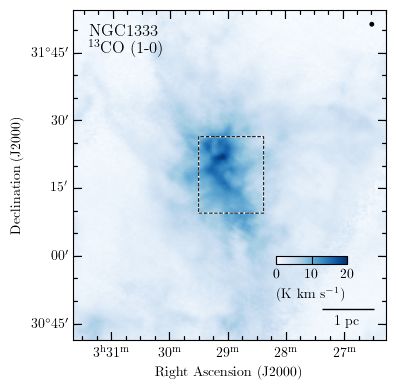

In [5]:
text_color = 'black'

hdu = fits.open(file_TdV_13co)[0]
wcs = WCS(hdu.header)

cmap = plt.get_cmap(name='Blues').copy()
cmap.set_bad(color='0.85')

fig = plt.figure(figsize=my_figsize)
ax = plt.subplot(projection=wcs)
im = ax.imshow(hdu.data, vmin=0.0, vmax=20.0, cmap=cmap, origin='lower')
ax.invert_xaxis()
ax.invert_yaxis()

plot_setup_ngc1333_wcsaxes(ax, hdu, label_col=text_color, telescope='FCRAO')

cax = ax.inset_axes(col_pos)
cbar = plt.colorbar(im, cax=cax, label=r'(K km s$^{-1}$)', 
                    orientation='horizontal')
cbar.set_ticks([0, 10, 20])

fig.text(xpos_lab1, ypos_lab1, 'NGC1333', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
fig.text(xpos_lab2, ypos_lab2, r'$^{13}$CO (1-0)', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)

plot_footprint(ax, file_list_TdV[1], color='k')
plt.tight_layout()
if save_figs:
    fig.savefig('figs/NGC1333_13CO_TdV.pdf', dpi=200, bbox_inches='tight')

Set OBSGEO-B to    19.825833 from OBSGEO-[XYZ].
Set OBSGEO-H to       -3.003 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


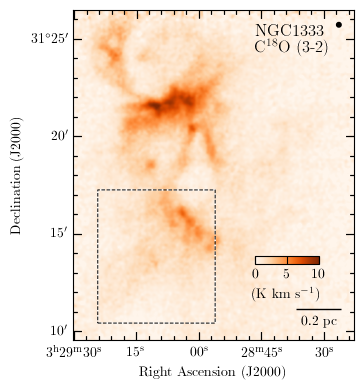

In [6]:
text_color = 'black'

hdu = fits.open(file_TdV_c18o)[0]
wcs = WCS(hdu.header)

cmap = plt.get_cmap(name='Oranges').copy()
cmap.set_bad(color='0.85')

fig = plt.figure(figsize=my_figsize)
ax = plt.subplot(projection=wcs)
im = ax.imshow(hdu.data, vmin=0.0, vmax=10, cmap=cmap, origin='lower')

plot_setup_ngc1333_wcsaxes(ax, hdu, label_col=text_color, telescope='JCMT')

cax = ax.inset_axes(col_pos)
cbar = plt.colorbar(im, cax=cax, label=r'(K km s$^{-1}$)', orientation='horizontal')
cbar.set_ticks([0, 5, 10])

fig.text(0.6 + xpos_lab1, ypos_lab1, 'NGC1333', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
fig.text(0.6 + xpos_lab2, ypos_lab2, r'C$^{18}$O (3-2)', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
plot_footprint(ax, file_list_TdV[2], color='k')
plt.tight_layout()
if save_figs:
    fig.savefig('figs/NGC1333_C18O_TdV.pdf', dpi=200, bbox_inches='tight')

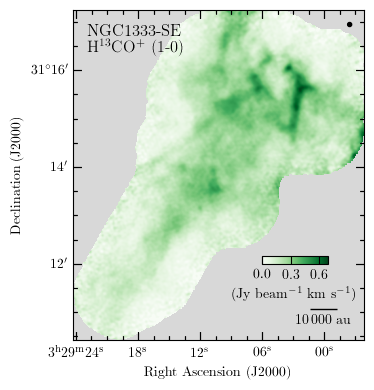

In [7]:
text_color = 'black'

hdu = fits.open(file_TdV_h13cop)[0]
wcs = WCS(hdu.header)

cmap = plt.get_cmap(name='Greens').copy()
cmap.set_bad(color='0.85')

fig = plt.figure(figsize=my_figsize)
ax = plt.subplot(projection=wcs)
im = ax.imshow(hdu.data, vmin=0.0, cmap=cmap, origin='lower')

plot_setup_ngc1333_wcsaxes(ax, hdu, label_col=text_color, telescope='NOEMA')

cax = ax.inset_axes(col_pos)
cbar = plt.colorbar(im, cax=cax, label=r'(Jy beam$^{-1}$ km s$^{-1}$)', orientation='horizontal')
cbar.set_ticks([0, 0.3, 0.6])

fig.text(xpos_lab1, ypos_lab1, 'NGC1333-SE', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
fig.text(xpos_lab2, ypos_lab2, r'H$^{13}$CO$^+$ (1-0)', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
plt.tight_layout()
if save_figs:
    fig.savefig('figs/NGC1333_H13COp_TdV.pdf', dpi=200, bbox_inches='tight')

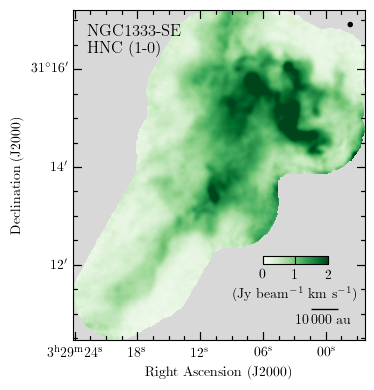

In [8]:
text_color = 'black'

hdu = fits.open(file_TdV_hnc)[0]
wcs = WCS(hdu.header)

cmap = plt.get_cmap(name='Greens').copy()
cmap.set_bad(color='0.85')

fig = plt.figure(figsize=my_figsize)
ax = plt.subplot(projection=wcs)
im = ax.imshow(hdu.data, vmin=0, vmax=2, cmap=cmap, origin='lower')

plot_setup_ngc1333_wcsaxes(ax, hdu, label_col=text_color, telescope='NOEMA')

cax = ax.inset_axes(col_pos)
cbar = plt.colorbar(im, cax=cax, label=r'(Jy beam$^{-1}$ km s$^{-1}$)', orientation='horizontal')
cbar.set_ticks([0, 1, 2])

fig.text(xpos_lab1, ypos_lab1, 'NGC1333-SE', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
fig.text(xpos_lab2, ypos_lab2, r'HNC (1-0)', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
plt.tight_layout()
if save_figs:
    fig.savefig('figs/NGC1333_HNC_TdV.pdf', dpi=200, bbox_inches='tight')

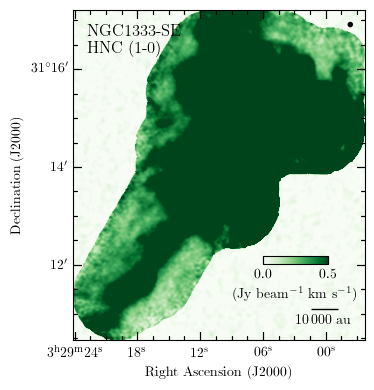

In [9]:
text_color = 'black'

hdu = fits.open(file_TdV_hnc_pad)[0]
wcs = WCS(hdu.header)

cmap = plt.get_cmap(name='Greens').copy()
cmap.set_bad(color='0.85')

fig = plt.figure(figsize=my_figsize)
ax = plt.subplot(projection=wcs)
im = ax.imshow(hdu.data, vmin=0, vmax=0.5, cmap=cmap, origin='lower')

plot_setup_ngc1333_wcsaxes(ax, hdu, label_col=text_color, telescope='NOEMA')

cax = ax.inset_axes(col_pos)
cbar = plt.colorbar(im, cax=cax, label=r'(Jy beam$^{-1}$ km s$^{-1}$)', orientation='horizontal')
# cbar.set_ticks([0, 0.1, 0.2, 0.3])

fig.text(xpos_lab1, ypos_lab1, 'NGC1333-SE', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
fig.text(xpos_lab2, ypos_lab2, r'HNC (1-0)', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
plt.tight_layout()
# fig.savefig('figs/NGC1333_HNC_TdV.pdf', dpi=200, bbox_inches='tight')

### Power Spectrum of Intensity

In [10]:
pspec_13co_TdV = pickle.load(open(file_pickle_13co, "rb" ))
pspec_13co_TdV_apod = pickle.load(open(file_pickle_13co_apod, "rb" ))

pspec_c18o_TdV = pickle.load(open(file_pickle_c18o, "rb" ))
pspec_c18o_TdV_apod = pickle.load(open(file_pickle_c18o_apod, "rb" ))

pspec_h13cop_TdV = pickle.load(open(file_pickle_h13cop, "rb" ))
pspec_h13cop_TdV_pad = pickle.load(open(file_pickle_h13cop_pad, "rb" ))

pspec_hnc_TdV = pickle.load(open(file_pickle_hnc, "rb" ))
pspec_hnc_TdV_pad = pickle.load(open(file_pickle_hnc_pad, "rb" ))

### Conversion of pixel units to pc

In [11]:
conv_13co = np.abs((pspec_13co_TdV_apod.header['CDELT1'] * u.deg.to('', equivalencies=u.dimensionless_angles()))*distance).to(u.pc)
conv_c18o = np.abs((pspec_c18o_TdV_apod.header['CDELT1'] * u.deg.to('', equivalencies=u.dimensionless_angles()))*distance).to(u.pc)
conv_h13cop = np.abs((pspec_h13cop_TdV.header['CDELT1'] * u.deg.to('', equivalencies=u.dimensionless_angles()))*distance).to(u.pc)
conv_hnc = np.abs((pspec_hnc_TdV.header['CDELT1'] * u.deg.to('', equivalencies=u.dimensionless_angles()))*distance).to(u.pc)

In [12]:
beam_multiple = 3.0
gd_13co_TdV = (pspec_13co_TdV_apod.freqs.value < np.abs(pspec_13co_TdV_apod.header['CDELT1']) / pspec_13co_TdV_apod.header['BMAJ'] / beam_multiple)
gd_c18o_TdV = (pspec_c18o_TdV_apod.freqs.value < np.abs(pspec_c18o_TdV_apod.header['CDELT1']) / pspec_c18o_TdV_apod.header['BMAJ'] / beam_multiple)

gd_h13cop_TdV = (pspec_h13cop_TdV.freqs.value < np.abs(pspec_h13cop_TdV.header['CDELT1']) / pspec_h13cop_TdV.header['BMAJ'] / beam_multiple)
gd_hnc_TdV = (pspec_hnc_TdV.freqs.value < np.abs(pspec_hnc_TdV.header['CDELT1']) / pspec_hnc_TdV.header['BMAJ'] / beam_multiple)

The goal is to combine the power-spectrum from the different tracers using scaling parameters for $^{13}$CO and  C$^{18}$O, $f_{13}$ and $f_{18}$. The model can be written as:
\begin{equation}
P(k) = A k^{\beta}~,
\end{equation}
where the data for C$^{18}$O is used as anchor.

Now we prepare all the frequencies and data points to be used in the fit.

In [13]:
ln_log = np.log10(np.exp(1))

# k_mhd_wave = (1. / 54e-3) # value from Pineda et al. (2023, CRIR)
k_mhd_wave = (1. / 34e-3) # value from Pineda et al. (2023, CRIR)
label_mhd_wave = r'34 mpc'
log_k_mhd_wave = np.log10(k_mhd_wave)

# 13CO 1-0
# linear and log quantities
#
freq_13co_TdV = (pspec_13co_TdV_apod.freqs[gd_13co_TdV] / conv_13co).value
log_freq_13co_TdV = np.log10(freq_13co_TdV)
#
P_TdV_13co = pspec_13co_TdV_apod.ps1D[gd_13co_TdV] * 1e-7
log_P_TdV_13co = np.log10(P_TdV_13co)
eP_TdV_13co = pspec_13co_TdV_apod.ps1D_stddev[gd_13co_TdV] * 1e-7
elogP_TdV_13co = ln_log * eP_TdV_13co / P_TdV_13co


# C18O 3-2
# linear and log quantities
#
freq_c18o_TdV = (pspec_c18o_TdV_apod.freqs[gd_c18o_TdV] / conv_c18o).value
log_freq_c18o_TdV = np.log10(freq_c18o_TdV)
#
# Normalization for C18O (3-2)
#
idx = np.abs(log_freq_c18o_TdV - 0.49).argmin()
rescale = pspec_c18o_TdV_apod.ps1D[idx]
#
#
P_TdV_c18o = pspec_c18o_TdV_apod.ps1D[gd_c18o_TdV] / rescale #* 1e-7
#
log_P_TdV_c18o = np.log10(P_TdV_c18o)
eP_TdV_c18o = pspec_c18o_TdV_apod.ps1D_stddev[gd_c18o_TdV] / rescale # * 1e-7
elogP_TdV_c18o = ln_log * eP_TdV_c18o / P_TdV_c18o

# H13CO+ 1-0
# linear and log quantities
#
freq_h13cop_TdV = (pspec_h13cop_TdV_pad.freqs[gd_h13cop_TdV] / conv_h13cop).value
log_freq_h13cop_TdV = np.log10(freq_h13cop_TdV)
#
P_TdV_h13cop = pspec_h13cop_TdV_pad.ps1D[gd_h13cop_TdV] * 1e-7
log_P_TdV_h13cop = np.log10(P_TdV_h13cop)
eP_TdV_h13cop = pspec_h13cop_TdV_pad.ps1D_stddev[gd_h13cop_TdV] * 1e-7
elogP_TdV_h13cop = ln_log * eP_TdV_h13cop / P_TdV_h13cop


# HNC 1-0
# linear and log quantities
#
freq_hnc_TdV = (pspec_hnc_TdV_pad.freqs[gd_hnc_TdV] / conv_hnc).value
log_freq_hnc_TdV = np.log10(freq_hnc_TdV)
#
P_TdV_hnc = pspec_hnc_TdV_pad.ps1D[gd_hnc_TdV] * 1e-7
log_P_TdV_hnc = np.log10(P_TdV_hnc)
eP_TdV_hnc = pspec_hnc_TdV_pad.ps1D_stddev[gd_hnc_TdV] * 1e-7
elogP_TdV_hnc = ln_log * eP_TdV_hnc / P_TdV_hnc


#
# Here we stitch all the frequencies together, but dropping the first
# frequency, since it is the most uncertain.
#
n_drop_f = 1

log_freq_all_hnc_TdV_f = np.append(log_freq_13co_TdV[n_drop_f:], 
                                 np.append(log_freq_c18o_TdV[n_drop_f:], 
                                           log_freq_hnc_TdV[n_drop_f:]))
log_freq_all_h13cop_TdV_f = np.append(log_freq_13co_TdV[n_drop_f:], 
                                    np.append(log_freq_c18o_TdV[n_drop_f:], 
                                              log_freq_h13cop_TdV[n_drop_f:]))

In this case, we want to have a single calibration of the 13CO amplitude. For this we will fit both power-laws simultaneously.

In [14]:
#
# Define functions for fitting. 
#
def power_law_spectrum(log_freq, A, beta):
    return A - log_freq * beta


def log_prior_TdV(theta):
    A_hnc, beta_hnc, A_h13cop, beta_h13cop, f_13, f_hnc, f_h13cop = theta
    if 1.0 < A_hnc < 2.5 and 2.0 < beta_hnc < 3.4 and \
       1.0 < A_h13cop < 2.5 and 2.0 < beta_h13cop < 3.4 and \
       2.0 < f_13 < 3.0 and -2.0 < f_hnc < -1.0 and -1.0 < f_h13cop < 0.5:
        return 0.0
    return -np.inf



def log_likelihood_log_TdV(theta):
    """ 
    Likelihood function for working on log-log for fitting all lines at the same time
    """
    # A, beta, f_13, f_hnc = theta
    A_hnc, beta_hnc, A_h13cop, beta_h13cop, f_13, f_hnc, f_h13cop = theta
    
    model_all_hnc = power_law_spectrum(log_freq_all_hnc_TdV_f, A_hnc, beta_hnc)
    
    log_P_TdV_all_hnc = np.append(f_13 + log_P_TdV_13co[n_drop_f:], 
                                  np.append(log_P_TdV_c18o[n_drop_f:], 
                                            f_hnc + log_P_TdV_hnc[n_drop_f:])
                                 )
    sigma_all_hnc = np.append(elogP_TdV_13co[n_drop_f:], 
                              np.append(elogP_TdV_c18o[n_drop_f:], 
                                        elogP_TdV_hnc[n_drop_f:])
                             )

    model_all_h13cop = power_law_spectrum(log_freq_all_h13cop_TdV_f, A_h13cop, beta_h13cop)
    log_P_TdV_all_h13cop = np.append(f_13 + log_P_TdV_13co[n_drop_f:],
                                     np.append(log_P_TdV_c18o[n_drop_f:], 
                                               f_h13cop + log_P_TdV_h13cop[n_drop_f:])
                                    )
    sigma_all_h13cop = np.append(elogP_TdV_13co[n_drop_f:], 
                                 np.append(elogP_TdV_c18o[n_drop_f:], 
                                           elogP_TdV_h13cop[n_drop_f:])
                                )
    return -0.5 * np.sum((log_P_TdV_all_h13cop - model_all_h13cop)**2 / sigma_all_h13cop**2) + \
           -0.5 * np.sum((log_P_TdV_all_hnc - model_all_hnc)**2 / sigma_all_hnc**2)


def log_probability_log_TdV(theta):
    lp = log_prior_TdV(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_log_TdV(theta)

In [15]:
print('Maximum spatial frequency: {0}'.format(np.max(log_freq_all_hnc_TdV_f)))

Maximum spatial frequency: 1.65752863187699


In [16]:
nll = lambda *args: -log_likelihood_log_TdV(*args)
initial = np.array([1.4, 3.0, 1.4, 3.0, 2.5, -1.5, -0.2])
soln_log_all = minimize(nll, initial)
print(soln_log_all.x)

[ 1.43514293  2.94550424  1.42305022  2.92156531  2.50934129 -1.50035785
 -0.2540829 ]


## Combine different datasets for plotting

In [17]:
l_pc = np.array([1e-2, 2e-2, 5e-2, 1e-1, 3e-1, 1, 10])
label_l_pc = ['', '20', '50', '100', '300', r'10$^3$', r'10$^4$']
k_pc = np.log10(1. / l_pc)

def plot_second_axis(ax):
    """
    Function to add second axis.
    """
    ax2 = ax.twiny()
    x_min, x_max = ax.get_xlim()
    # use same range as the original axis
    ax2.set_xlim(x_min, x_max)
    #
    ax2.set_xlabel('Physical scale (mpc)')
    gd = (k_pc <= x_max) & (x_min <= k_pc)
    label_full = []
    for gd_i, label_i in zip(gd, label_l_pc):
        if gd_i:
            label_full.append(label_i)
    ax2.set_xticks(k_pc[gd])
    ax2.set_xticklabels(label_full)
    return


def add_k_mhd(ax, y_k_mhd):
    """
    Function to add annotation for MHD dissipation scale
    """
    # y_k_mhd = -0.8
    ax.plot([log_k_mhd_wave, log_k_mhd_wave], y_k_mhd + np.array([-0.75, 1.2]), color='gray')
    ax.text(log_k_mhd_wave, y_k_mhd + 1.5, label_mhd_wave, horizontalalignment='center')
    return
# y_k_mhd = power_law_spectrum(log_k_mhd_wave, A, beta)
# ax.plot([log_k_mhd_wave, log_k_mhd_wave], y_k_mhd + np.array([-0.75, 1.2]), color='gray')
# ax.text(log_k_mhd_wave, y_k_mhd + 1.5, label_mhd_wave, horizontalalignment='center')

def plot_powerspectrum(ax, solution, 
                       do_hnc=True, label_power_fit=None, 
                       plot_gray=False):
    """
    Convenience function plotting for combined spatial power spectrum
    """
    A = solution[0]
    beta = solution[1]
    f_data1 = solution[2]
    f_data3 = solution[3]

    if label_power_fit == None:
        label_power_fit = r'$\propto k^{-'
        label_power_fit = label_power_fit + '{0}'.format(np.round(beta, decimals=2)) + '}$'
    
    label_1 = r'$^{13}$CO'
    label_2 = r'C$^{18}$O'
    text_pspec = 'Intensity Power Spectrum (Beam Corrected)'
    #
    log_x_data1 = log_freq_13co_TdV
    log_y_data1 = f_data1 + log_P_TdV_13co
    elog_y_data1 = elogP_TdV_13co
    #
    log_x_data2 = log_freq_c18o_TdV
    log_y_data2 = log_P_TdV_c18o
    elog_y_data2 = elogP_TdV_c18o
    if do_hnc:
        log_x_data3 = log_freq_hnc_TdV
        log_y_data3 = f_data3 + log_P_TdV_hnc
        elog_y_data3 = elogP_TdV_hnc
        label_3 = r'HNC'
    else:
        log_x_data3 = log_freq_h13cop_TdV
        log_y_data3 = f_data3 + log_P_TdV_h13cop
        elog_y_data3 = elogP_TdV_h13cop
        label_3 = r'H$^{13}$CO$^+$'
    
    if plot_gray:
        ax.errorbar(log_x_data1, log_y_data1, yerr=elog_y_data1, 
                    alpha=0.5, markeredgecolor='k', fmt="o", 
                    ecolor='gray', markerfacecolor='gray')
        ax.errorbar(log_x_data2, log_y_data2, yerr=elog_y_data2, 
                    alpha=0.5, markeredgecolor='k', fmt="o",
                    ecolor='gray', markerfacecolor='gray')
        ax.errorbar(log_x_data3, log_y_data3, yerr=elog_y_data3, 
                    alpha=0.5, markeredgecolor='k', fmt="o",
                    ecolor='gray', markerfacecolor='gray')
    else:
        ax.errorbar(log_x_data1, log_y_data1, yerr=elog_y_data1, 
                alpha=0.5, markeredgecolor='k', label=label_1, fmt="o")
        ax.errorbar(log_x_data2, log_y_data2, yerr=elog_y_data2, 
                alpha=0.5, markeredgecolor='k', label=label_2, fmt="o")
        ax.errorbar(log_x_data3, log_y_data3, yerr=elog_y_data3, 
                alpha=0.5, markeredgecolor='k', label=label_3, fmt="o")
        plt.legend(frameon=False)

    x_sample = np.log10(np.array([0.3, 50]))
    ax.plot(x_sample, power_law_spectrum(x_sample, A, beta), color='w', lw=3, ls=':', zorder=20)
    ax.plot(x_sample, power_law_spectrum(x_sample, A, beta), color='k', lw=2, ls=':', zorder=21)

    
    ax.set_xlabel(r'Spatial Frequency, $\log k$ (pc$^{-1}$)')
    ax.set_ylabel(r'log ($PS_2(k)$), (Arbitrary Units)')
 
    ax.text(0.1, power_law_spectrum(-0.1, A, beta) + 0.4, label_power_fit, horizontalalignment='center')

    add_k_mhd(ax, power_law_spectrum(log_k_mhd_wave, A, beta))

    ax.set_xlim(-1, 2)
    plt.tight_layout()
    return

### Intensity Power Spectrum

In [18]:
# A_hnc, beta_hnc, A_h13cop, beta_h13cop, f_13, f_hnc, f_h13cop = theta
id_hnc = [0, 1, 4, 5]
id_h13cop = [2, 3, 4, 6]

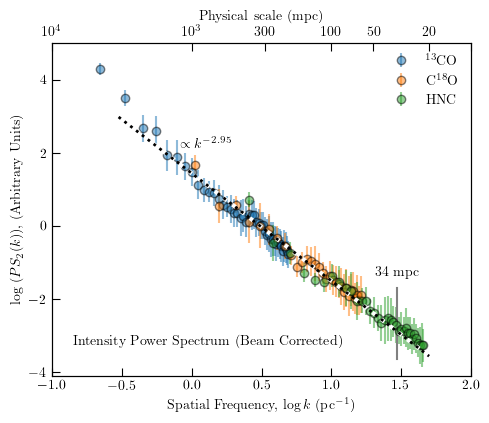

In [19]:
fig, ax = plt.subplots(figsize=(5, 4))
plot_powerspectrum(ax, soln_log_all.x[id_hnc], do_hnc=True)

text_pspec = 'Intensity Power Spectrum (Beam Corrected)'
ax.text(0.05, 0.09, text_pspec, horizontalalignment='left', transform=ax.transAxes)
ax.set_ylim(-4.1, 5)
plot_second_axis(ax)
if save_figs:
    fig.savefig('figs/NGC1333_Intensity_Power_Spectrum_Arb_fit_HNC_log.pdf', bbox_inches='tight')

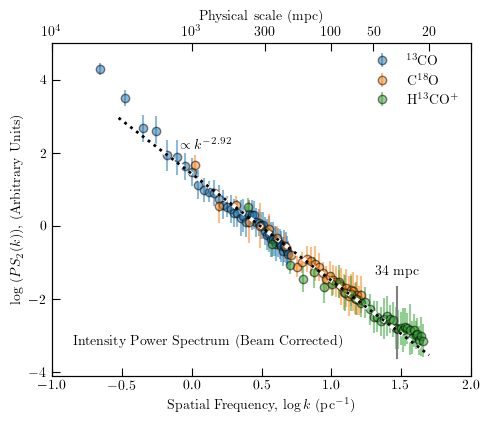

In [20]:
fig, ax = plt.subplots(figsize=(5, 4))
plot_powerspectrum(ax, soln_log_all.x[id_h13cop], do_hnc=False)

text_pspec = 'Intensity Power Spectrum (Beam Corrected)'
ax.text(0.05, 0.09, text_pspec, horizontalalignment='left', transform=ax.transAxes)
ax.set_ylim(-4.1, 5)
plot_second_axis(ax)
if save_figs:
    fig.savefig('figs/NGC1333_Intensity_Power_Spectrum_Arb_fit_H13COp_log.pdf', bbox_inches='tight')

#### Add comparison between Ions and Neutrals at the smallest scales

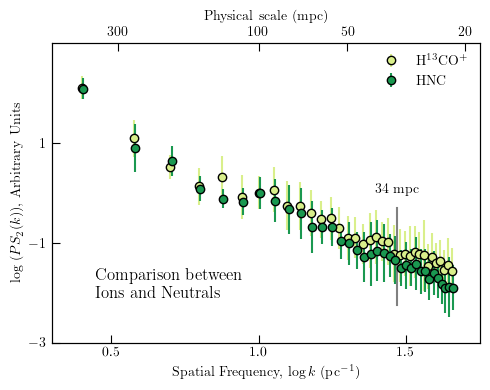

In [21]:
fig, ax = plt.subplots(figsize=(5, 4))

# Normalisation of the power spectra
# search for index closest to 1
idx = np.abs(log_freq_h13cop_TdV - 1).argmin()
rescale_ion = log_P_TdV_h13cop[idx]

idx = np.abs(log_freq_hnc_TdV - 1).argmin()
rescale_neutral = log_P_TdV_hnc[idx]

color_HCOp = '#d9ef8b'
color_HNC = '#1a9850'

ax.errorbar(log_freq_h13cop_TdV, log_P_TdV_h13cop - rescale_ion, yerr=elogP_TdV_h13cop, 
            markeredgecolor='k', label='H$^{13}$CO$^+$', fmt="o", 
            ecolor=color_HCOp, markerfacecolor=color_HCOp)
ax.errorbar(log_freq_hnc_TdV, log_P_TdV_hnc - rescale_neutral, yerr=elogP_TdV_hnc, 
            markeredgecolor='k', label='HNC', fmt="o", 
            ecolor=color_HNC, markerfacecolor=color_HNC)

add_k_mhd(ax, -1.5)

plt.legend(frameon=False)

text_pspec = 'Comparison between\n Ions and Neutrals'
ax.text(0.1, 0.15, text_pspec, horizontalalignment='left', transform=ax.transAxes, size=12)

# ax.set_xlabel(r'log (Spatial Frequency) (pc$^{-1}$)')
ax.set_xlabel(r'Spatial Frequency, $\log k$ (pc$^{-1}$)')
ax.set_ylabel(r'log ($PS_2(k)$), Arbitrary Units')
ax.set_xlim(0.3, 1.75)
ax.set_ylim(-3, 3)

ax.xaxis.set_ticks(np.arange(0.5, 1.8, 0.5))
ax.yaxis.set_ticks(np.arange(-3, 3, 2))
plot_second_axis(ax)
plt.tight_layout()
if save_figs:
    fig.savefig('figs/NGC1333_Intensity_Power_Spectrum_Arb_compare_Ion_Neutral.pdf', bbox_inches='tight')

## EMCEE power-law fit
### Intensity for H$^{13}$CO$^+$

In [22]:
pos = soln_log_all.x + 1e-4 * np.random.randn(56, np.size(soln_log_all.x))
nwalkers, ndim = pos.shape

if os.path.isfile(file_EMCEE_All):
    sampler = emcee.backends.HDFBackend(file_EMCEE_All, read_only=True)
else:
    backend = emcee.backends.HDFBackend(file_EMCEE_All)
    backend.reset(nwalkers, ndim)
    sampler = emcee.EnsembleSampler(
        nwalkers, ndim, log_probability_log_TdV, backend=backend
    )
    sampler.run_mcmc(pos, 50000, progress=True);

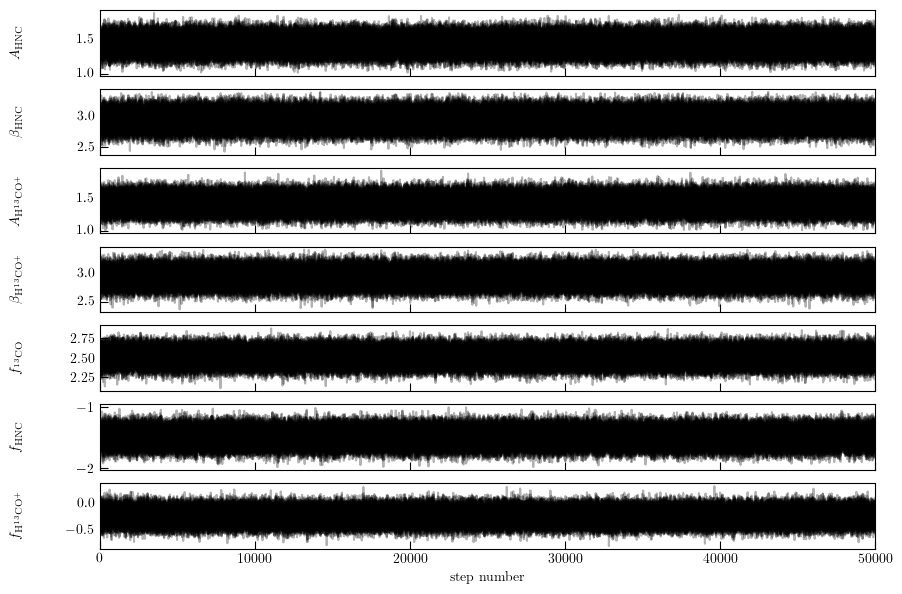

In [23]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
# A_hnc, beta_hnc, A_h13cop, beta_h13cop, f_13, f_hnc, f_h13cop = theta
labels = [r"$A_{\rm HNC}$", r"$\beta_{\rm HNC}$", 
          r"$A_{\rm H^{13}CO^+}$", r"$\beta_{\rm H^{13}CO^+}$", 
          r"$f_{\rm ^{13}CO}$", r"$f_{\rm HNC}$",
          r"$f_{\rm H^{13}CO^+}$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [24]:
tau = sampler.get_autocorr_time()
print(tau)
flat_samples = sampler.get_chain(discard=600, thin=40, flat=True)

[79.64552141 79.99471609 77.40819526 78.61116446 78.45370088 78.63622875
 81.90628299]


'\\mathrm{$A_{\\rm HNC}$} = 1.43_{-0.10}^{+0.10}'

'\\mathrm{$\\beta_{\\rm HNC}$} = 2.95_{-0.11}^{+0.11}'

'\\mathrm{$A_{\\rm H^{13}CO^+}$} = 1.42_{-0.10}^{+0.10}'

'\\mathrm{$\\beta_{\\rm H^{13}CO^+}$} = 2.92_{-0.11}^{+0.11}'

'\\mathrm{$f_{\\rm ^{13}CO}$} = 2.51_{-0.08}^{+0.08}'

'\\mathrm{$f_{\\rm HNC}$} = -1.50_{-0.11}^{+0.11}'

'\\mathrm{$f_{\\rm H^{13}CO^+}$} = -0.25_{-0.11}^{+0.11}'

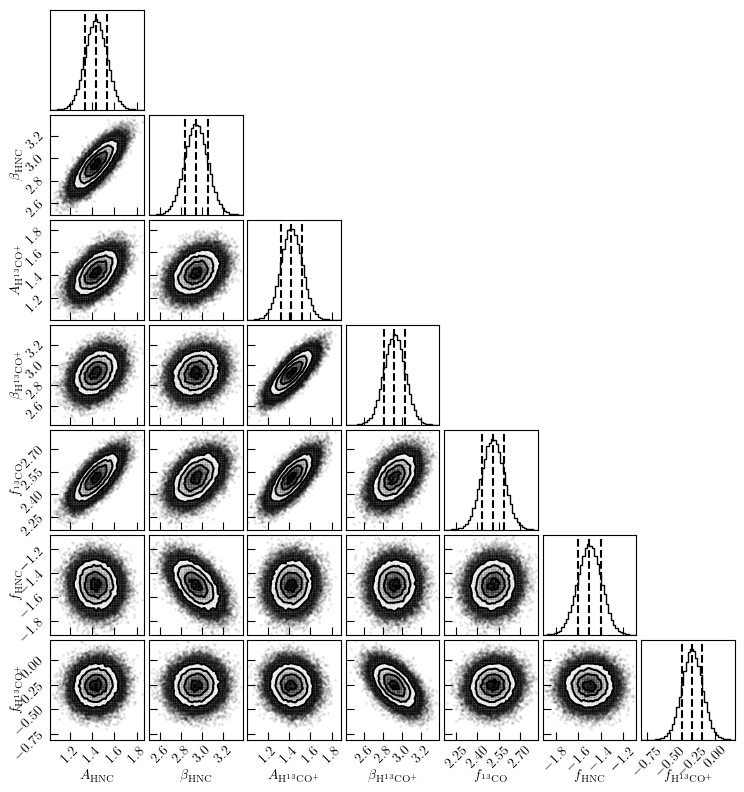

In [25]:
fig_my = plt.figure(figsize=(7.5, 8))

fig = corner.corner(
    flat_samples, 
    labels=labels,
    quantiles=[0.16, 0.5, 0.84],
    show_titles=False,
    bins=40, fig=fig_my, color='k')

soln_log_all_EMCEE = np.zeros(ndim)
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.2f}_{{-{1:.2f}}}^{{{2:+.2f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display((txt))
    soln_log_all_EMCEE[i] = mcmc[1]
    if i == 1:
        label_beta = r'$\propto k^{'
        label_beta = label_beta + '{0:.2f}_{{-{1:.2f}}}^{{{2:+.2f}}}'.format(mcmc[1], q[0], q[1]) + '}$'
if save_figs:
    fig.savefig('figs/EMCEE_corner_All.pdf')

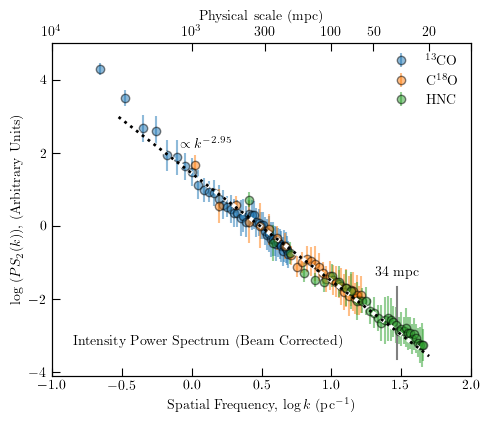

In [26]:
fig, ax = plt.subplots(figsize=(5, 4))
plot_powerspectrum(ax, soln_log_all_EMCEE[id_hnc], do_hnc=True)

ax.set_ylim(-4.1, 5)
text_pspec = 'Intensity Power Spectrum (Beam Corrected)'
ax.text(0.05, 0.09, text_pspec, horizontalalignment='left', transform=ax.transAxes)
plot_second_axis(ax)
if save_figs:
    fig.savefig('figs/NGC1333_Intensity_Power_Spectrum_Arb_EMCEE_HNC_log.pdf', bbox_inches='tight')

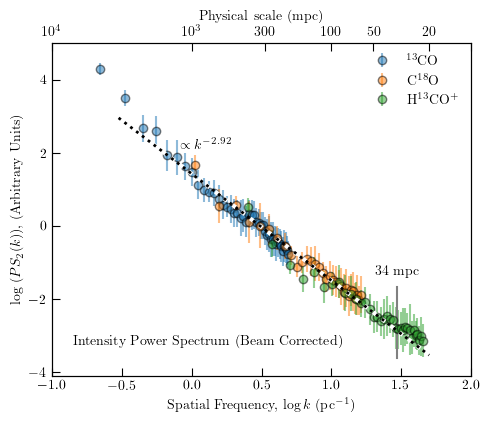

In [27]:
fig, ax = plt.subplots(figsize=(5, 4))
plot_powerspectrum(ax, soln_log_all_EMCEE[id_h13cop], do_hnc=False)

ax.set_ylim(-4.1, 5)
text_pspec = 'Intensity Power Spectrum (Beam Corrected)'
ax.text(0.05, 0.09, text_pspec, horizontalalignment='left', transform=ax.transAxes)
plot_second_axis(ax)
if save_figs:
    fig.savefig('figs/NGC1333_Intensity_Power_Spectrum_Arb_EMCEE_H13COp_log.pdf', bbox_inches='tight')

Now we export the LaTeX table with the summary of the fits.

In [28]:
print("\\begin{tabular}{lc}")
print("\\hline \hline")
print("Parameter & Value \\\\")
print("\\hline")
for i in range(ndim):
    # Create percentiles
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q_all = np.diff(mcmc)
    
    txt = "{{{3}}} & ${0:.2f}_{{-{1:.2f}}}^{{{2:+.2f}}}$ \\\\"
    txt_all = txt.format(mcmc[1], q_all[0], q_all[1], labels[i])
   
    print(txt_all)

print("\\hline")
print("\\end{tabular}")

\begin{tabular}{lc}
\hline \hline
Parameter & Value \\
\hline
{$A_{\rm HNC}$} & $1.43_{-0.10}^{+0.10}$ \\
{$\beta_{\rm HNC}$} & $2.95_{-0.11}^{+0.11}$ \\
{$A_{\rm H^{13}CO^+}$} & $1.42_{-0.10}^{+0.10}$ \\
{$\beta_{\rm H^{13}CO^+}$} & $2.92_{-0.11}^{+0.11}$ \\
{$f_{\rm ^{13}CO}$} & $2.51_{-0.08}^{+0.08}$ \\
{$f_{\rm HNC}$} & $-1.50_{-0.11}^{+0.11}$ \\
{$f_{\rm H^{13}CO^+}$} & $-0.25_{-0.11}^{+0.11}$ \\
\hline
\end{tabular}


### Dissipation Scale
We take the Crutcher relation to estimate the MHD dissipation scale. Notice that the relation is given as a function of $n(\rm{H})$, while we derived $n(\rm{H_2})$, which are related as $n(\rm{H}) = 2\times n(\rm{H_2})$.

In [29]:
from uncertainties import ufloat

mean_n_H2 = 10**(3.6) / u.cm**3
mean_X_e = 10**(-6.5)
sig_v = 1.69e-9*u.cm**3/u.s

gauss_B = (u.g/u.cm)**(0.5)/u.s
equiv_B = [(u.G, gauss_B, lambda x: x, lambda x: x)]

def Bfield_Crutcher(density):
    """
    Magnetic field strength as a function of volume density 
    """
    B_init = 10 * u.uG
    # Density in paper is n(H) = 2 n(H2)
    density_init = 2 * 300 / u.cm**3
    alpha_init = 0.65
    if (density < density_init):
        return B_init
    else:
        return B_init * np.power(density / density_init, alpha_init)

lamda_MHD = (np.sqrt(np.pi/(4 * 2.8 * u.u * mean_n_H2).cgs) 
             * Bfield_Crutcher(mean_n_H2).to((u.g/u.cm)**(1/2)/u.s, equivalencies=equiv_B) 
             / (mean_n_H2 * mean_X_e * sig_v)).to(u.pc)

def lambda_simple(n_H2, alpha_B=1.5):
    lambda_simple = lamda_MHD.value * (n_H2 / mean_n_H2.value)**(0.65 - alpha_B)
    return lambda_simple

In [30]:
print(np.round(lamda_MHD, decimals=3))
print(np.round(lamda_MHD, decimals=3).to(u.au))

0.034 pc
7013.003412401277 AU


In [31]:
lamda_MHD.to(u.au)

<Quantity 7002.14253325 AU>

We now use the mean density and its uncertainty to show the uncertainty on the dissipation scale.

In [32]:
mean_n_H2_unc = 10**(ufloat(3.6, 0.2))

In [33]:
lambda_unc = lambda_simple(mean_n_H2_unc)

In [34]:
print(lambda_unc)

0.034+/-0.013
